In [44]:
import yfinance as yf
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from backtesting import Strategy, Backtest
import backtesting
backtesting.set_bokeh_output(notebook=True)

### Automated Rayner Teo Strategy

- Using daily timeframe and 2 EMAs for trend detection 
- Customize slow and fast EMAs length
- Customize Bollinger Bands length and STD
- Low price of candle closing below lower BB - put buy order at perc% distance from the current closing price
- Increasing the perc% will decrease the number of trades, increasing slectivness
- If order is transofrmed into open order, close trade using the RSI as exit signal or after a certain number of days
- A selective strategy like this will not have higer number of trades in the daily timeframe
- If a second signal is detected, the first order is closed and only the second is kept
- Only one order is allowed at the same time
- Optimize parameters for keeping losses low during drawdown periods like shown in the equity curve

Original strategy on Code Trading YT channel: https://www.youtube.com/watch?v=f6Nh4guZPRs

### Data & Indicators

In [45]:
def get_data(symbol: str):
    ''' Using 10 years of data on daily timeframe from yfinance
    '''
    data = yf.download(tickers=symbol, period='10y', interval='1d')
    data.columns = data.columns.droplevel(-1)
    data.reset_index(inplace=True)
    data.columns.name=''
    return data

data = get_data('^GSPC') #S&P500
data.tail()

[*********************100%***********************]  1 of 1 completed


,Date,Adj Close,Close,High,Low,Open,Volume
2512,2024-12-03 00:00:00+00:00,6049.879883,6049.879883,6052.069824,6033.390137,6042.970215,4095000000
2513,2024-12-04 00:00:00+00:00,6086.490234,6086.490234,6089.839844,6061.060059,6069.390137,4003390000
2514,2024-12-05 00:00:00+00:00,6075.109863,6075.109863,6094.549805,6072.899902,6089.029785,4212020000
2515,2024-12-06 00:00:00+00:00,6090.270020,6090.270020,6099.970215,6079.979980,6081.379883,3924830000
2516,2024-12-09 00:00:00+00:00,6066.490234,6066.490234,6088.509766,6053.970215,6083.009766,1040996000


In [46]:
data['EMA']=ta.ema(data.Close, length=200)
data['EMA2']=ta.ema(data.Close, length=150)
data['RSI']=ta.rsi(data.Close, length=12)
my_bbands = ta.bbands(data.Close, length=14, std=2.0)
data=data.join(my_bbands)
data.dropna(inplace=True)
data.reset_index(inplace=True)
data.tail()

,index,Date,Adj Close,Close,High,Low,Open,Volume,EMA,EMA2,RSI,BBL_14_2.0,BBM_14_2.0,BBU_14_2.0,BBB_14_2.0,BBP_14_2.0
2313,2512,2024-12-03 00:00:00+00:00,6049.879883,6049.879883,6052.069824,6033.390137,6042.970215,4095000000,5467.386860,5585.158336,68.105580,5860.439890,5970.577114,6080.714337,3.689333,0.860018
2314,2513,2024-12-04 00:00:00+00:00,6086.490234,6086.490234,6089.839844,6061.060059,6069.390137,4003390000,5473.547092,5591.798493,71.671906,5852.508509,5977.799282,6103.090054,4.191869,0.933755
2315,2514,2024-12-05 00:00:00+00:00,6075.109863,6075.109863,6094.549805,6072.899902,6089.029785,4212020000,5479.532791,5598.199968,69.053522,5853.208196,5986.794992,6120.381787,4.462715,0.830552
2316,2515,2024-12-06 00:00:00+00:00,6090.270020,6090.270020,6099.970215,6079.979980,6081.379883,3924830000,5485.609779,5604.717453,70.613669,5875.741175,6002.484270,6129.227366,4.223021,0.846314
2317,2516,2024-12-09 00:00:00+00:00,6066.490234,6066.490234,6088.509766,6053.970215,6083.009766,1040996000,5491.389684,5610.833648,65.005784,5899.774230,6014.832136,6129.890041,3.825806,0.724487


### EMA signal

In [47]:
def addemasignal(df):
    ''' Calculate trend comparing fast and slow EMA
     '''
    emasignal = [0]*len(df)
    for i in range(0, len(df)):
        if df.EMA2[i]>df.EMA[i]:
            emasignal[i]=2
        elif df.EMA2[i]<df.EMA[i]:
            emasignal[i]=1
    df['EMASignal'] = emasignal
    
addemasignal(data)

### Order limit signal %

In [48]:
def addorderslimit(df, percent):
    ''' percent parameter is the % distance, 0 is less selective
    '''
    ordersignal=[0]*len(df)
    for i in range(1, len(df)):
        if  df.Close[i]<=df['BBL_14_2.0'][i] and df.EMASignal[i]==2:
            ordersignal[i]=df.Close[i]-df.Close[i]*percent
        elif df.Close[i]>=df['BBU_14_2.0'][i] and df.EMASignal[i]==1:
            ordersignal[i]=df.Close[i]+df.Close[i]*percent
    df['ordersignal']=ordersignal
    
addorderslimit(data, 0.000)

In [49]:
data[data.ordersignal!=0]

,index,Date,Adj Close,Close,High,Low,Open,Volume,EMA,EMA2,RSI,BBL_14_2.0,BBM_14_2.0,BBU_14_2.0,BBB_14_2.0,BBP_14_2.0,EMASignal,ordersignal
21,220,2015-10-23 00:00:00+00:00,2075.149902,2075.149902,2079.739990,2058.189941,2058.189941,4108460000,2052.007630,2034.289273,69.798779,1973.383114,2020.532846,2067.682578,4.667059,1.079187,1,2075.149902
168,367,2016-05-25 00:00:00+00:00,2090.540039,2090.540039,2094.729980,2078.929932,2078.929932,3859160000,2030.562970,2027.990426,60.354614,2031.139727,2060.278564,2089.417402,2.828631,1.019264,1,2090.540039
189,388,2016-06-24 00:00:00+00:00,2037.410034,2037.410034,2103.810059,2032.569946,2103.810059,7597450000,2042.031075,2043.356762,36.454805,2044.513623,2087.587149,2130.660676,4.126633,-0.082459,2,2037.410034
190,389,2016-06-27 00:00:00+00:00,2000.540039,2000.540039,2031.449951,1991.680054,2031.449951,5431220000,2041.618229,2042.789653,29.868112,2019.666337,2079.616446,2139.566556,5.765497,-0.159518,2,2000.540039
215,414,2016-08-02 00:00:00+00:00,2157.030029,2157.030029,2170.199951,2147.580078,2169.939941,3848750000,2063.992645,2071.342595,54.954180,2157.900900,2167.510725,2177.120550,0.886715,-0.045311,2,2157.030029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2221,2420,2024-07-24 00:00:00+00:00,5427.129883,5427.129883,5508.040039,5419.979980,5505.839844,3945550000,5045.042595,5156.349475,39.142706,5460.176981,5573.884347,5687.591713,4.080004,-0.145316,2,5427.129883
2222,2421,2024-07-25 00:00:00+00:00,5399.220215,5399.220215,5491.589844,5390.950195,5428.700195,4592120000,5048.566751,5159.566306,36.786285,5416.775470,5561.886509,5706.997549,5.218051,-0.060489,2,5399.220215
2229,2428,2024-08-05 00:00:00+00:00,5186.330078,5186.330078,5250.890137,5119.259766,5151.140137,5333250000,5072.813301,5181.589045,28.536126,5258.343350,5460.379325,5662.415300,7.400071,-0.178219,2,5186.330078
2252,2451,2024-09-06 00:00:00+00:00,5408.419922,5408.419922,5522.470215,5402.620117,5507.330078,3822800000,5161.679382,5267.525980,38.811155,5450.252050,5576.248570,5702.245090,4.519042,-0.166005,2,5408.419922


### Visualization

In [50]:
def pointposbreak(x):
    ''' Visualize the signal points of the ordersignal
    '''
    if x['ordersignal']!=0:
        return x['ordersignal']
    else:
        return np.nan
    
data['pointposbreak'] = data.apply(lambda row: pointposbreak(row), axis=1)

dfpl = data[-500:].copy()

fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close']),
                go.Scatter(x=dfpl.index, y=dfpl.EMA, line=dict(color='orange', width=2), name="EMA"),
                go.Scatter(x=dfpl.index, y=dfpl.EMA2, line=dict(color='yellow', width=2), name="EMA2"),        
                go.Scatter(x=dfpl.index, y=dfpl['BBL_14_2.0'], line=dict(color='blue', width=1), name="BBL"),
                go.Scatter(x=dfpl.index, y=dfpl['BBU_14_2.0'], line=dict(color='blue', width=1), name="BBU")])

fig.add_scatter(x=dfpl.index, y=dfpl['pointposbreak'], mode="markers",
                marker=dict(size=6, color="MediumPurple"),
                name="Signal")
fig.update_xaxes(rangeslider_visible=False)
fig.update_layout(autosize=False, width=600, height=600,margin=dict(l=50,r=50,b=100,t=100,pad=4), paper_bgcolor="white")
fig.show()

### Strategy backtest

In [51]:
dfpl = data[:].copy()
def SIGNAL():
    return dfpl.ordersignal

class MyStrat(Strategy):
    ''' Includes TPSL % apart from RSI conditions'''
    initsize = 0.99
    mysize = initsize
    TPSLRatio = 2
    perc = 0.02
    
    def init(self):
        super().init()
        self.signal = self.I(SIGNAL)

    def next(self):
        super().next()

        if len(self.trades)>0:
            #check if there are open trades
            #close if trade is opened for more than 10 days
            if self.data.index[-1]-self.trades[-1].entry_time>=10:
                self.trades[-1].close()
            if self.trades[-1].is_long and self.data.RSI[-1]>=75:
                self.trades[-1].close()
            elif self.trades[-1].is_short and self.data.RSI[-1]<=25:
                self.trades[-1].close()

        if self.signal!=0 and len(self.trades)==0 and self.data.EMASignal==2:  
            sl1 = min(self.data.Low[-1],self.data.Low[-2])*(1-self.perc)
            tp1 = self.data.Close[-1]+(self.data.Close[-1] - sl1)*self.TPSLRatio
            self.buy(sl=sl1, tp=tp1, size=self.mysize)
        
        elif self.signal!=0 and len(self.trades)==0 and self.data.EMASignal==1:         
            sl1 = sl1 = max(self.data.High[-1],self.data.High[-2])*(1+self.perc)
            tp1 = self.data.Close[-1]-(sl1 - self.data.Close[-1])*self.TPSLRatio
            self.sell(sl=sl1, tp=tp1, size=self.mysize)

bt = Backtest(dfpl, MyStrat, cash=10000, margin=1/10, commission=.00)
stat = bt.run()

#### Stats

In [52]:
stat

Start                                     0.0
End                                    2317.0
Duration                               2317.0
Exposure Time [%]                   26.833477
Equity Final [$]                122283.379106
Equity Peak [$]                 377654.591509
Return [%]                        1122.833791
Buy & Hold Return [%]               213.96153
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                  -90.829828
Avg. Drawdown [%]                  -12.867947
Max. Drawdown Duration                  806.0
Avg. Drawdown Duration              50.902439
# Trades                                 83.0
Win Rate [%]                        53.012048
Best Trade [%]                       6.123616
Worst Trade [%]                     -5.902495
Avg. Trade [%]                    

In [53]:
print(f"Returns: {stat["Return [%]"]:.2f}%")
print(f"Number of Trades: {stat["# Trades"]}")
print(f"Maximum Drawdown: {stat["Max. Drawdown [%]"]:.2f}%")
print(f"Average Drawdown: {stat["Avg. Drawdown [%]"]:.2f}%")
print(f"Win Rate: {stat["Win Rate [%]"]:.2f}%")
print(f"Best Trade: {stat["Best Trade [%]"]:.2f}%")
print(f"Worst Trade: {stat["Worst Trade [%]"]:.2f}%")
print(f"Average Trade: {stat["Avg. Trade [%]"]:.2f}%")
print(f"Maximum Trade Duration: {stat["Max. Trade Duration"]} days")
print(f"Average Trade Duration: {stat["Avg. Trade Duration"]:.2f} days")

Returns: 1122.83%
Number of Trades: 83.0
Maximum Drawdown: -90.83%
Average Drawdown: -12.87%
Win Rate: 53.01%
Best Trade: 6.12%
Worst Trade: -5.90%
Average Trade: 0.65%
Maximum Trade Duration: 11.0 days
Average Trade Duration: 6.49 days


In [54]:
bt.plot()

GridPlot(id='p3936', ...)

#### Equity curve

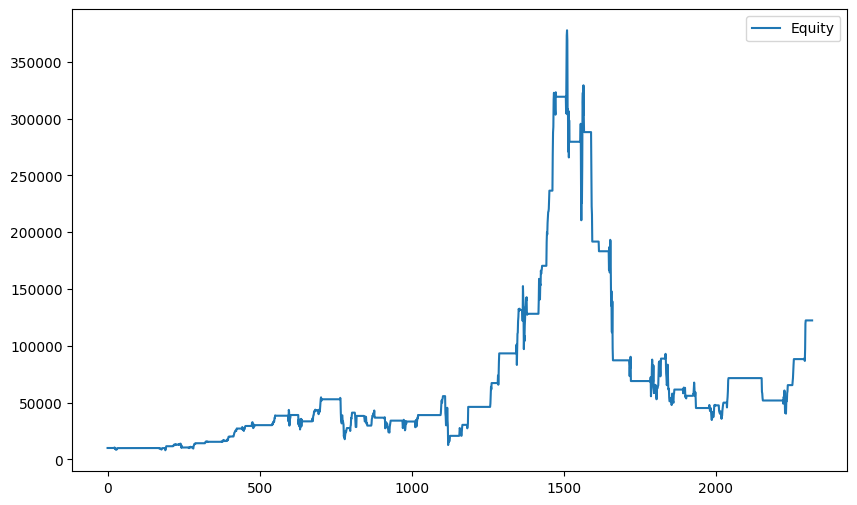

In [55]:
equity_curve = stat['_equity_curve']['Equity']
equity_curve.plot(kind='line', figsize=(10, 6), legend=True).set_facecolor('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.gca().tick_params(axis='x', colors='black')
plt.gca().tick_params(axis='y', colors='black')
plt.gca().set_facecolor('white')

### Optimization

In [56]:
#optimize the stategy for range of sl/tp %
#including small commision to account for the spread
#no risk of overfitting as we are not optimizing any indicator

bt = Backtest(dfpl, MyStrat, cash=10000, margin=1/5, commission=0.0002)
stats, heatmap = bt.optimize(perc=[i/100 for i in range(1, 8)],
                                TPSLRatio=[i for i in range(1, 8)],
                maximize='Return [%]', max_tries=3000,
                    random_state=0,
                    return_heatmap=True)

  0%|          | 0/5 [00:00<?, ?it/s]

#### Heatmap

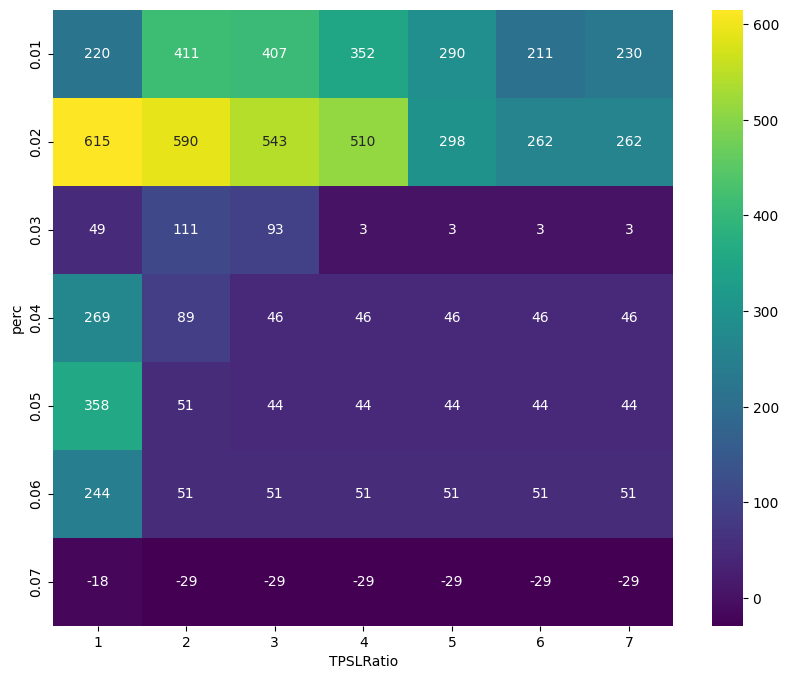

In [57]:
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap.unstack(), annot=True, cmap='viridis', fmt='.0f')
plt.show()